In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# for the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer


# from feature-engine
#from feature_engine import missing_data_imputers as mdi
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
import feature_engine.missing_data_imputers as mdi
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
from pathlib import Path
models_folder = Path("/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/models/")
data_folder = Path("/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/data/")

In [2]:
import utils as util

In [2]:
import pandas as pd

Review this :https://www.kaggle.com/udita3996/eda-woe-iv-calc-model-training

In [3]:

#data = pd.read_csv(data_folder/'raw/Train.csv')
data = pd.read_csv("/Users/joaosantos/Documents/Study/ML_DevOps/DeployProject/data/census.csv")
# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(32561, 15)


,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
len(data)

32561

In [5]:
# Check if missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
# source: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe

missing_values_table(data)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [6]:
# Find Continuous and Categorical Features
def featureType(df):
    import numpy as np 
    from pandas.api.types import is_numeric_dtype

    columns = df.columns
    rows= len(df)
    colTypeBase=[]
    colType=[]
    for col in columns:
        try:
            try:
                uniq=len(np.unique(df[col]))
            except:
                 uniq=len(df.groupby(col)[col].count())
            if rows>10:
                if is_numeric_dtype(df[col]):
                    
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Binary')
                    elif rows/uniq>3 and uniq>5:
                        colType.append('Continuous')
                        colTypeBase.append('Continuous')
                    else:
                        colType.append('Continuous-Ordinal')
                        colTypeBase.append('Ordinal')
                else:
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Category-Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Category-Binary')
                    else:
                        colType.append('Categorical-Nominal')
                        colTypeBase.append('Nominal')
            else:
                if is_numeric_dtype(df[col]):
                    colType.append('Numeric')
                    colTypeBase.append('Numeric')
                else:
                    colType.append('Non-numeric')
                    colTypeBase.append('Non-numeric')
        except:
            colType.append('Issue')
                
    # Create dataframe    
    df_out =pd.DataFrame({'Feature':columns,
                          'BaseFeatureType':colTypeBase,
                        'AnalysisFeatureType':colType})
    return df_out

featureType(data)  

,Feature,BaseFeatureType,AnalysisFeatureType
0,age,Continuous,Continuous
1,workclass,Nominal,Categorical-Nominal
2,fnlgt,Ordinal,Continuous-Ordinal
3,education,Nominal,Categorical-Nominal
4,education-num,Continuous,Continuous
5,marital-status,Nominal,Categorical-Nominal
6,occupation,Nominal,Categorical-Nominal
7,relationship,Nominal,Categorical-Nominal
8,race,Nominal,Categorical-Nominal
9,sex,Category-Binary,Binary


In [7]:
#import pandas_profiling
#data.profile_report()

# Understand Types

In [8]:
# let's inspect the type of variables in pandas
data.dtypes

age                 int64
 workclass         object
 fnlgt              int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
 salary            object
dtype: object

In [9]:
# let's inspect the variable values
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

age [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59] 

 workclass [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

 fnlgt [ 77516  83311 215646 234721 338409 284582 160187 209642  45781 159449
 280464 141297 122272 205019 121772 245487 176756 186824  28887 292175] 

 education [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th'] 

 education-num [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8] 

 marital-status [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 

 occupation [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv'

# Distribuition of Target Variable

<AxesSubplot:xlabel='labels'>

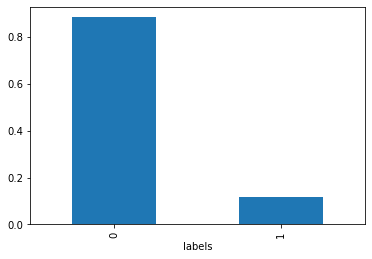

In [28]:
(data.groupby('labels')['labels'].count() / len(data)).plot.bar()


# Identify data Types

In [29]:
# make list of variables  types
dates = [var for var in data.columns if 'Date' in var or 'Year' in var]


# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='label' and 2< data[var].nunique()<20 and var not in dates]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='label' and var not in discrete and var not in dates]
binary_num = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype!='O' and var!='label']
binary_cat = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype=='O' and var!='label']
# mixed
mixed = []

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var!='label' and var not in mixed and var not in binary_cat and var not in binary_num]

print('There are {} date variables'.format(len(dates)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} binary categorical variables'.format(len(binary_cat)))
print('There are {} binary numeric variables'.format(len(binary_num)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))


There are 0 date variables
There are 6 discrete variables
There are 0 binary categorical variables
There are 4 binary numeric variables
There are 11 continuous variables
There are 0 categorical variables
There are 0 mixed variables


In [30]:
continuous

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_10',
 'feature_11',
 'feature_12',
 'labels']

In [31]:
dates

[]

In [32]:
discrete

['feature_7',
 'feature_8',
 'feature_9',
 'feature_13',
 'feature_14',
 'feature_15']

In [33]:
binary_cat

[]

In [34]:
binary_num

['feature_10', 'feature_11', 'feature_12', 'labels']

In [35]:
categorical

[]

# Missing Values analisys

In [36]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum()>=1]

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')
    

In [37]:
def analyse_na_value(df, var):
    df = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's calculate the mean SalePrice where the information is missing or present
    df.groupby(var)['label'].count().plot.bar()
    plt.title(var)
    plt.show()


for var in vars_with_na:
    analyse_na_value(data, var)
    

# Cardinality (number of different categories)

In [38]:
# cardinality (number of different categories)

data[categorical+mixed+discrete].nunique()

feature_7     12
feature_8      3
feature_9      4
feature_13     3
feature_14    12
feature_15     4
dtype: int64

# Distribuition of the Variables - Levels

## Continuous

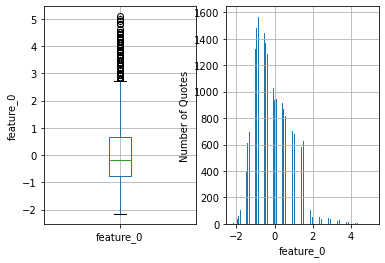

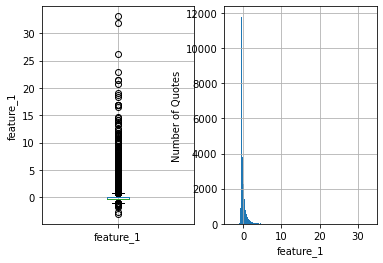

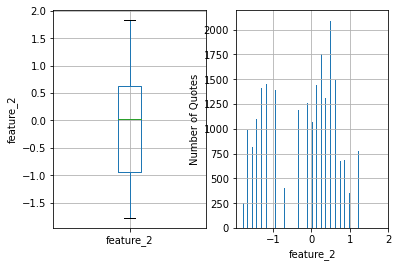

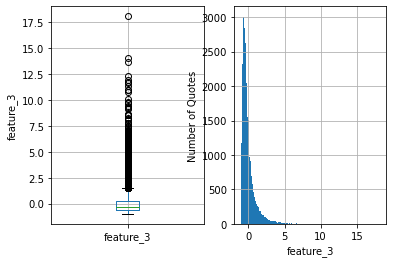

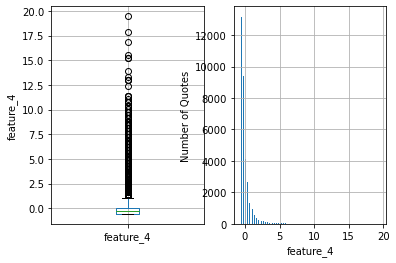

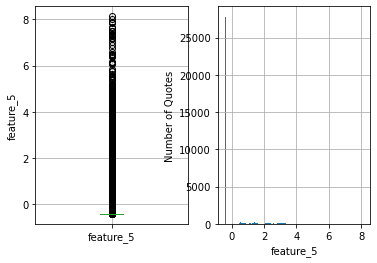

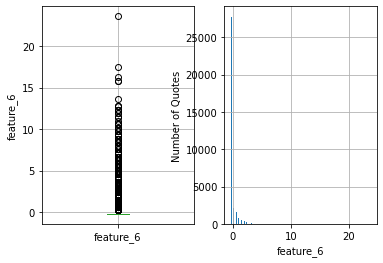

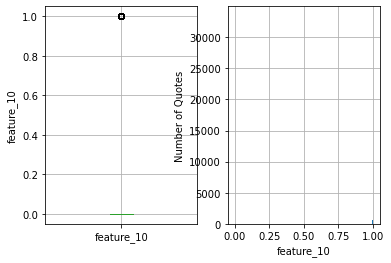

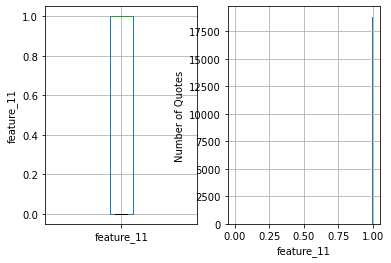

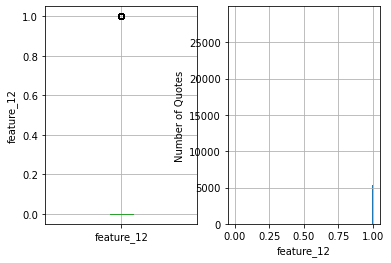

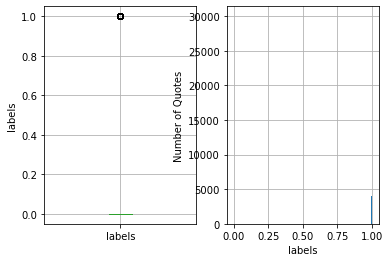

In [39]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=200)
    fig.set_ylabel('Number of Quotes')
    fig.set_xlabel(var)

    plt.show()

## Discrete

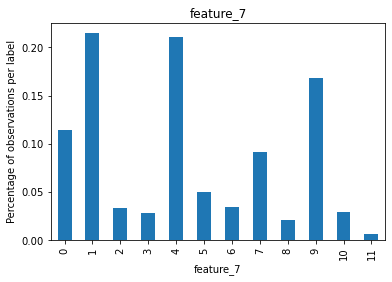

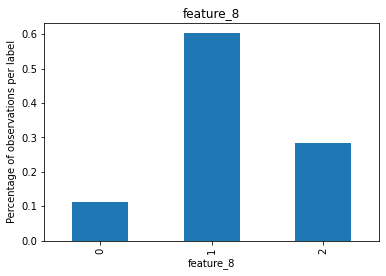

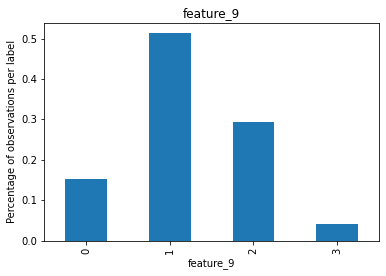

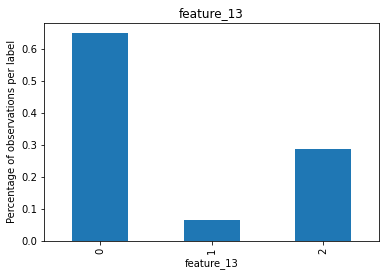

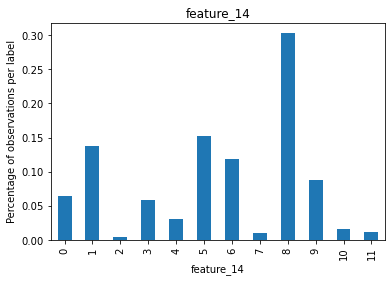

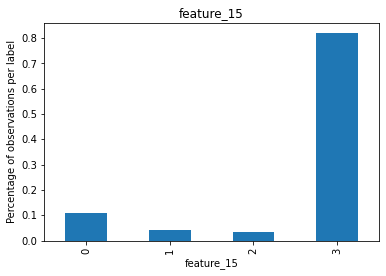

In [40]:
# outliers in discrete variables
for var in discrete+categorical:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

# Binary data

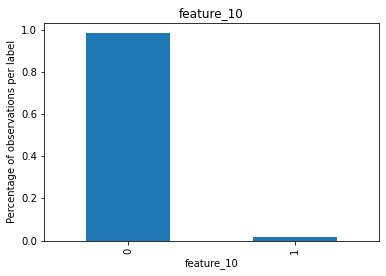

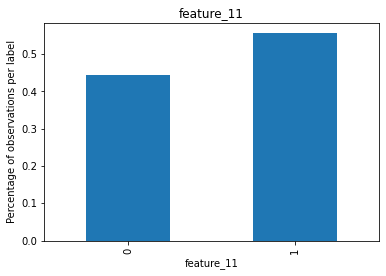

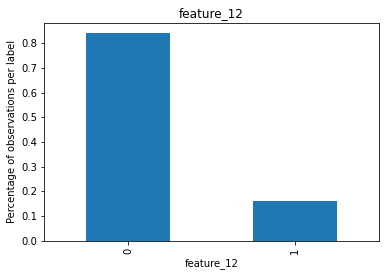

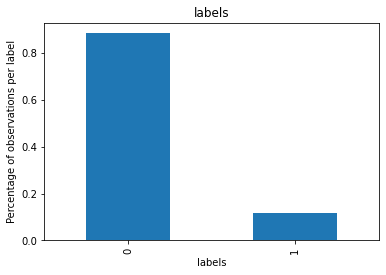

In [41]:
# outliers in discrete variables
for var in binary_num+binary_cat:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

## Rare Labels

In [42]:
#def analyse_rare_labels(df, var, rare_perc):
#    df = df.copy()
#    tmp = df.groupby(var)['SalePrice'].count() / len(df)
#    return tmp[tmp<rare_perc]

#for var in categorical:
#    print(analyse_rare_labels(data, var, 0.01))
#    print()

In [43]:
#for var in categorical:
#    plt.figure(figsize=(6,4))
#    plt.subplot(1, 2, 1)
#    fig1 = data.groupby([var,'QuoteConversion_Flag']).size().unstack().plot(kind='bar', stacked=True)
#    fig1.set_title('')
#    fig1.set_ylabel(var)
    
#    plt.subplot(1, 2, 2)
#    fig2 = data.groupby([var])['QuoteConversion_Flag'].mean().plot.bar()
    #fig.set_ylabel('% of Conversions')
    #fig.set_xlabel(var)
#    plt.show()

## Split the data

### Get the variables types updated

In [44]:
# make list of variables  types
dates = [var for var in data.columns if 'Date' in var or 'Year' in var]


# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='label' and 2< data[var].nunique()<15 and var not in dates]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='label' and var not in discrete and var not in dates]
binary_num = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype!='O' and var!='label']
binary_cat = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype=='O' and var!='label']
# mixed
mixed = []

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var!='label' and var not in mixed and var not in binary_cat and var not in binary_num]

print('There are {} date variables'.format(len(dates)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} binary categorical variables'.format(len(binary_cat)))
print('There are {} binary numeric variables'.format(len(binary_num)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 0 date variables
There are 6 discrete variables
There are 0 binary categorical variables
There are 4 binary numeric variables
There are 11 continuous variables
There are 0 categorical variables
There are 0 mixed variables


# Separate into train and test set

In [45]:
# Let's separate into train and test set
X_train, X_test, y_train, y_test = train_test_split(data.drop(['labels'], axis=1),
                                                    data['labels'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((23735, 16), (10173, 16))

In [46]:
X_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
32360,-0.370689,0.772721,0.503892,-0.979179,4.595294,-0.411453,-0.25194,7,2,0,0,1,0,2,6,3
20382,2.266183,0.268243,-1.418634,-0.567569,1.367391,-0.411453,-0.25194,3,1,0,0,1,0,0,11,3
14911,-1.029906,-0.456287,0.263576,-0.750075,-0.569351,-0.411453,-0.25194,7,1,1,0,1,0,0,5,3
31694,-0.182341,-0.447419,1.585313,-0.287984,-0.246560,-0.411453,-0.25194,4,1,2,0,1,0,2,8,3
8584,0.382703,-0.457272,-1.178318,-0.361763,-0.246560,-0.411453,-0.25194,6,1,1,0,1,1,2,6,3


### Save datasets

In [47]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv(data_folder /'processed/xtrain.csv', index=False, header=True)
X_test.to_csv(data_folder /'processed/xtest.csv', index=False, header=True)

y_train.to_csv(data_folder /'processed/ytrain.csv', index=False, header=True)
y_test.to_csv(data_folder /'processed/ytest.csv', index=False, header=True)

missing inputatio for discrete 